In [1]:
import os
import random
import pandas as pd
import numpy as np
from glob import glob
import tensorflow_io as tfio
import matplotlib.pyplot as plt
plt.style.use("ggplot")


import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array , array_to_img
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
# the lists that will contain the paths to the image, path
image_paths = []
# get all the mask images from the data directory
mask_paths = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
print(mask_paths[0:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif']


In [3]:
# the original images is the same excep that there is no  "_mask" in the path 
for img_path in mask_paths:
    image_paths.append(img_path.replace('_mask',''))
# now print first 5 images
print(image_paths[0:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']


In [4]:
image_list_ds = tf.data.Dataset.list_files(image_paths, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_paths, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)


(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'>)


In [5]:
# concatenate the image paths to form the all_dataset
image_files = tf.constant(image_paths)
masks_files = tf.constant(mask_paths)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, masks_files))
# print first three paths of the data 
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', shape=(), dtype=string)
tf.Tensor(b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', shape=(), dtype=string)


In [7]:
# function that takes both image & mask path and return the image
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = img[:,:,0:3]
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)
    # take only the 3 channels
    mask = mask[:,:,0:3]
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask


def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask

In [8]:
# apply the functions to all the data
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [9]:
processed_image_ds.element_spec

(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

In [10]:
# take some images from the data 
images = [image[0]  for image in list(processed_image_ds.take(5))]
masks = [mask[1] for mask in list(processed_image_ds.take(5))]

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         plt.axis('off')
    plt.show()

In [12]:
# show the shape of the new mask [ for the loss fucntion ]
print(f"mask shape : {masks[0].shape}")
print(f"image shape : {images[2].shape}") 

mask shape : (128, 128, 1)
image shape : (128, 128, 3)


<Figure size 1500x1500 with 0 Axes>

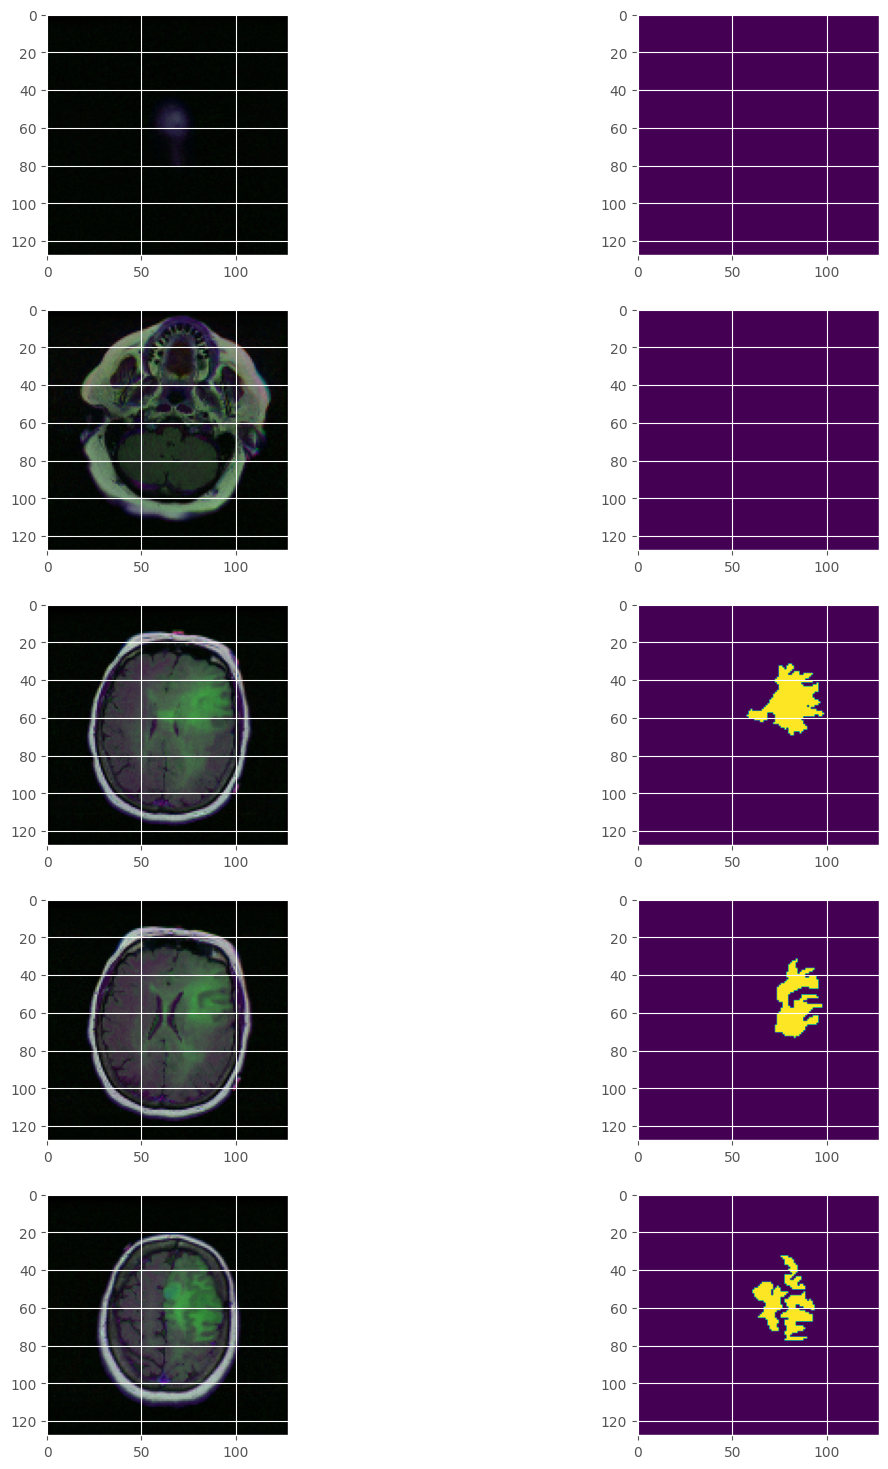

In [13]:
plt.figure(figsize=(15,15))
fig, axarr = plt.subplots(5,2,figsize=(15, 15))
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(masks[0])
axarr[1,0].imshow(images[1])
axarr[1,1].imshow(masks[1])
axarr[2,0].imshow(images[2])
axarr[2,1].imshow(masks[2])
axarr[3,0].imshow(images[3])
axarr[3,1].imshow(masks[3])
axarr[4,0].imshow(images[4])
axarr[4,1].imshow(masks[4])
fig.tight_layout(pad=1.8)

In [14]:
# number of images in the data
len(processed_image_ds) 

3929

In [15]:
# Cash the data 
BUFFER_SIZE = 1000
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
Full_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
Full_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [17]:
# number of batches in the data
len_data = len(Full_dataset) 
len_data

123

In [18]:
# split the data
train_size = int(len_data *.9 )
val_size = int(len_data *.05) 
test_size = len_data - train_size - val_size
train_size , test_size ,val_size

(110, 7, 6)

In [19]:
train_ds = Full_dataset.take(train_size)
test_ds = Full_dataset.skip(train_size).take(test_size)
val_ds = Full_dataset.skip(train_size + test_size) 

In [20]:
len(train_ds),len(test_ds),len(val_ds)

(110, 7, 6)

In [21]:
def customUNETConv(inputs=None,n_filters=32 ,dropout=0,max_pooling=True):
    """
    Custom Convolution block made for UNET, its a basic implementation of UNET Blocks.
    
    inputs : input from the previos block
    n_filters : number of filters
    dropout : the probalility to use dropout
    max_pooling : to use max_pooling or not
    Return : the volume for the next block
    
    """
    # first conv layer
    conv = Conv2D(
                  n_filters, # number of filters
                  3,# kernel_size
                  activation="relu",
                  padding="same", # the output is same size as input
                  kernel_initializer="he_normal" # better as weight initializer
                 )(inputs)
     # second conv layer
    conv = Conv2D(
                  n_filters, # number of filters
                  3,# kernel_size
                  activation="relu",
                  padding="same", # the output is same size as input
                  kernel_initializer="he_normal" # i found it better as weight initializer
                 )(conv)
    # apply the dropout if exists 
    if dropout > 0:
        # add dopout layer
        conv = Dropout(dropout)(conv)
    # apply the max_pooling if spicified
    if max_pooling:
        # if there is max_pool then add the layer 
        out_to_next = MaxPooling2D(2)(conv)
    else:
        out_to_next = conv
    # the output to the skip connection shouldn't go through the max_pooling
    # so , i will take it before the max_pooling layer
    out_to_skip = conv
    return out_to_next , out_to_skip

In [22]:
# build the upsampling block 
def customUNETUpsample(previos_output, skip_output, n_filters=32):
    """
    Custom Upsamling block for UNET, it upsamples the features which were previously downsampled by the CustomConv maxpooling
    """
    # first the transpose convolutional layer
    up_sample = Conv2DTranspose(
                         n_filters,    # number of filters
                         3,    # Kernel_size
                         strides=(2,2), # stride 2 to expand the input in reveres to the max_pool layer
                         padding="same" # add padding
                        )(previos_output)
    # now, concatenate the output from this layer to the skip_output
    concate = concatenate([up_sample,skip_output],axis=3) # axis=3 means concate along the channel axis
    # first conv block
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(concate)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(conv)
    return conv

In [23]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(256, 256, 3), n_filters=32):
    # start with the downsampling part
    inputs = Input(input_size)
    conv_block1 = customUNETConv(inputs, n_filters)
    conv_block2 = customUNETConv(conv_block1[0], n_filters *2)
    conv_block3 = customUNETConv(conv_block2[0], n_filters * 4)
    conv_block4 = customUNETConv(conv_block3[0], n_filters *8, dropout=.3) 
    conv_block5 = customUNETConv(conv_block4[0], n_filters *16, dropout=.3, max_pooling=False) 
    # The upsampling part
    up_block1 = customUNETUpsample(conv_block5[0], conv_block4[1],  n_filters * 8)
    up_block2 = customUNETUpsample(up_block1, conv_block3[1],  n_filters * 4)
    up_block3 = customUNETUpsample(up_block2, conv_block2[1],  n_filters * 2)
    up_block4 = customUNETUpsample(up_block3, conv_block1[1],  n_filters )

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up_block4)

    # output part
    conv10 = Conv2D(2, 1, padding="same")(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [24]:
img_height = 128
img_width = 128
num_channels = 3
unet = unet_model((img_height, img_width, num_channels))

In [25]:
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,639,778 (32.96 MB)

 Trainable params: 8,639,778 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# compile the model
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# train the model
history = unet.fit(train_ds,
                   validation_data=val_ds,
                   epochs=50,    
                  )

Epoch 1/50


I0000 00:00:1731157401.880164      97 service.cc:145] XLA service 0x7ba90000a010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731157401.880221      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1731157402.522332      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  2/110 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.5944 - loss: 0.6270  

I0000 00:00:1731157415.718583      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9643 - loss: 0.4842

W0000 00:00:1731157429.899441     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731157430.514714      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9645 - loss: 0.4816 - val_accuracy: 0.9881 - val_loss: 0.0320
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9911 - loss: 0.0278 - val_accuracy: 0.9928 - val_loss: 0.0216
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9924 - loss: 0.0262 - val_accuracy: 0.9941 - val_loss: 0.0176
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9938 - loss: 0.0207 - val_accuracy: 0.9946 - val_loss: 0.0156
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9942 - loss: 0.0176 - val_accuracy: 0.9947 - val_loss: 0.0159
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9940 - val_loss: 0.0194
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9949 - loss: 0.0157 - val_accuracy: 0.9955 - val_loss: 0.0126
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9955 - loss: 0.0138 - val_accuracy: 0.9

Text(0.5, 1.0, 'Accuraccy Curve')

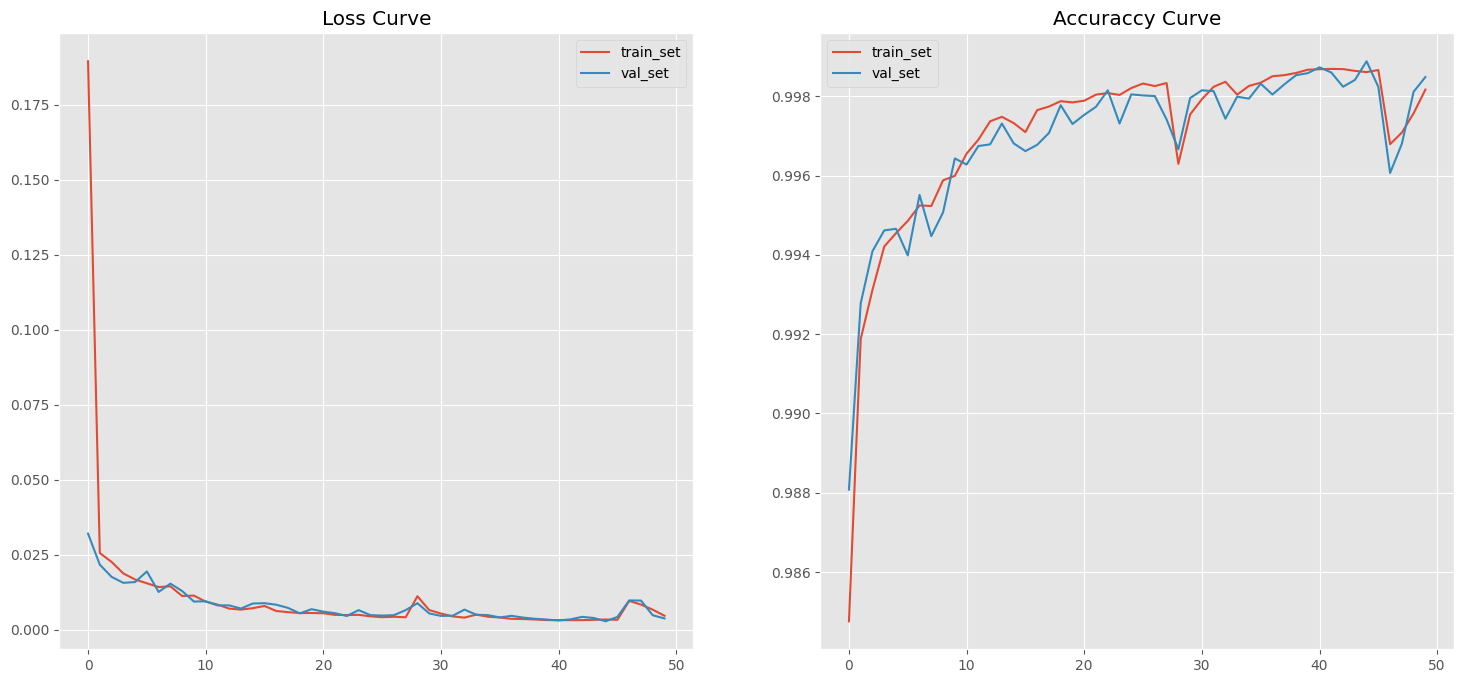

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(18, 8))
# the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_set')
plt.plot(history.history['val_loss'], label='val_set')
plt.legend()
plt.title('Loss Curve')
# the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_set')
plt.plot(history.history['val_accuracy'], label='val_set')
plt.legend()
plt.title('Accuraccy Curve')

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [30]:
def display(display_list):
    plt.figure(figsize=(15, 50))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [31]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


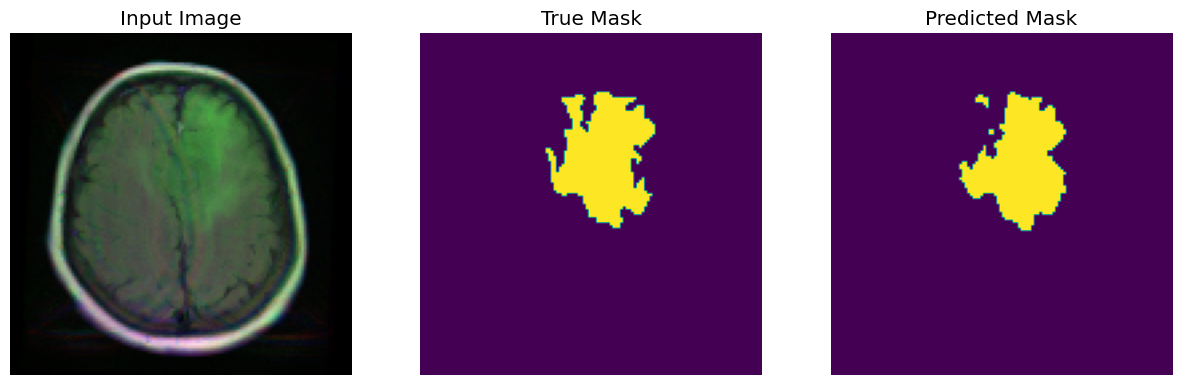

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


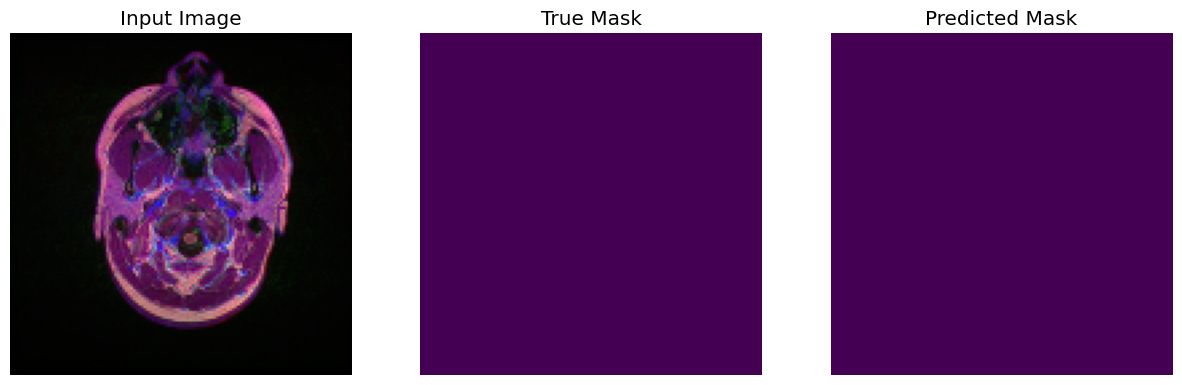

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


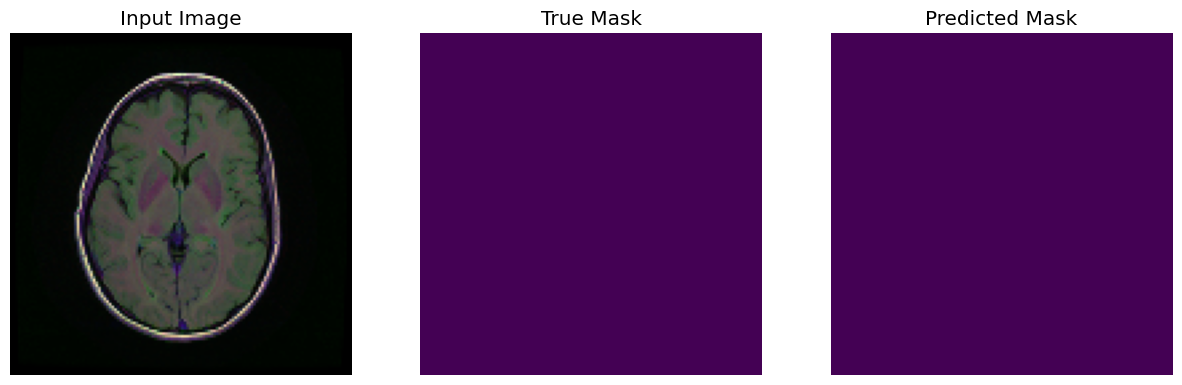

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


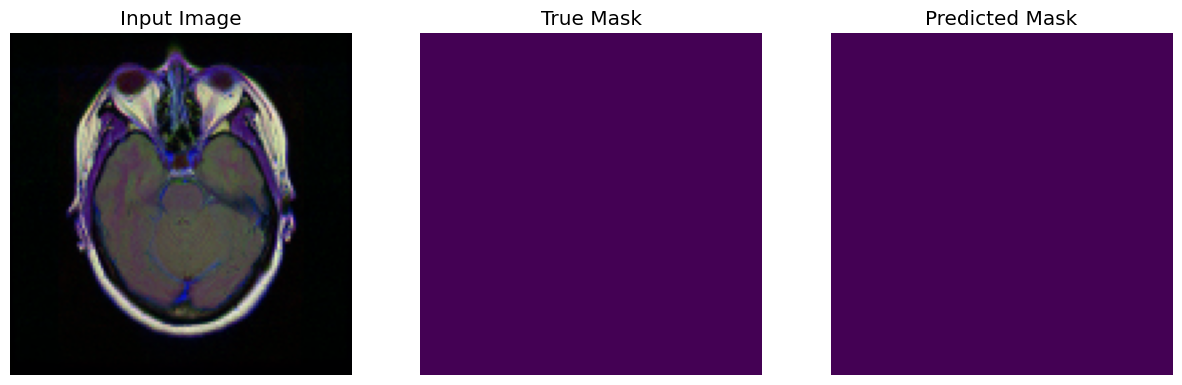

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


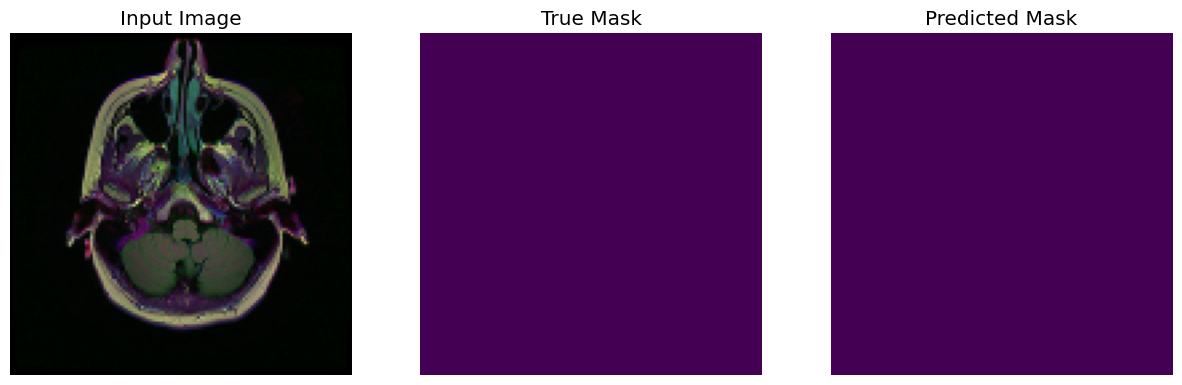

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


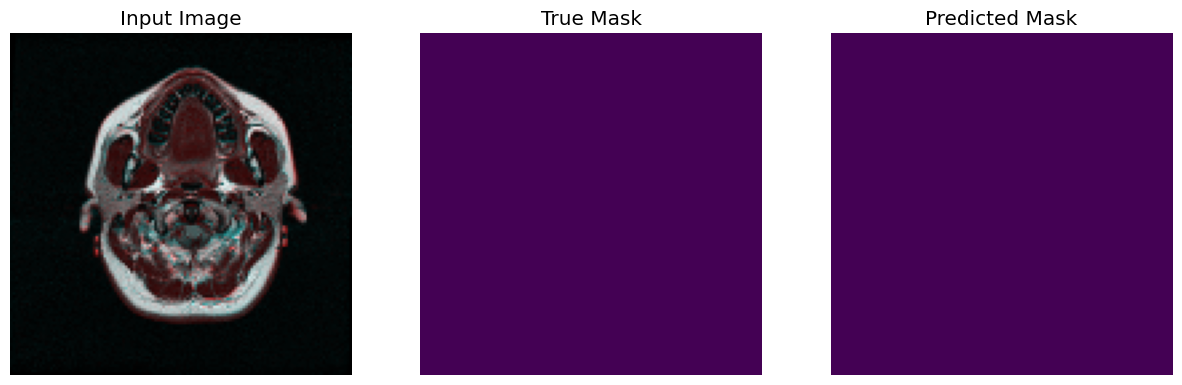

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


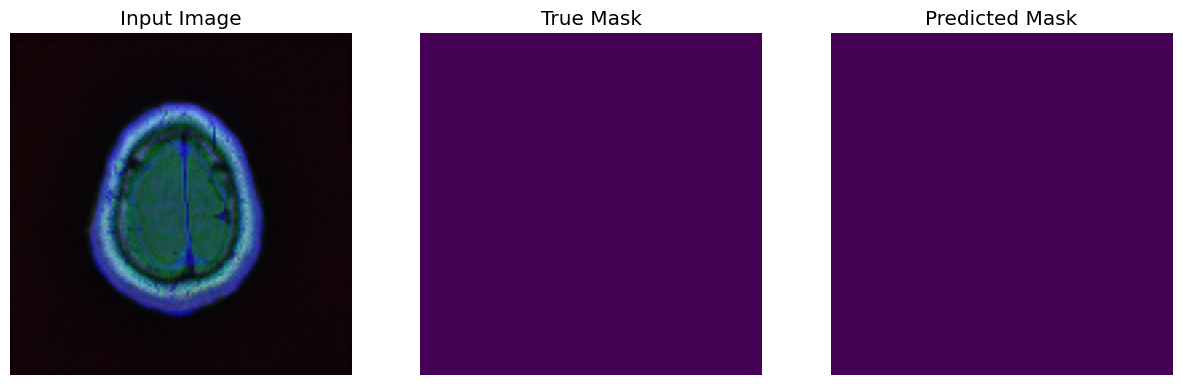

In [32]:
show_predictions(test_ds,10)

In [34]:
unet.save('/kaggle/working/BrainMRISegment-Predictor.keras')

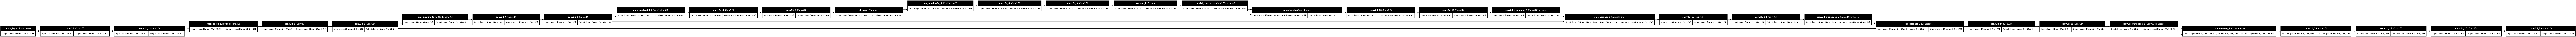

In [43]:
from tensorflow.keras.utils import plot_model
plot_model(unet, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'LR', 
           expand_nested = False, 
           dpi = 70)